### MLP 
(MNIST Tutorial: https://medium.com/@aungkyawmyint_26195/multi-layer-perceptron-mnist-pytorch-463f795b897a)

Libraries

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

Data Preparation

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2# convert data to torch.FloatTensor
transform = transforms.ToTensor()# choose the training and testing datasets
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, 
                                           sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                          sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         num_workers = num_workers)

Network architecture

In [3]:
import torch.nn as nn
import torch.nn.functional as F# define NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28*28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512,512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512,10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.droput = nn.Dropout(0.2)
        
    def forward(self,x):
        # flatten image input
        x = x.view(-1,28*28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.droput(x)
         # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.droput(x)
        # add output layer
        x = self.fc3(x)
        return x# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (droput): Dropout(p=0.2, inplace=False)
)


Loss function and optimiser

In [4]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

CUDA

In [5]:
# check if CUDA is available (to increase performance)
cuda = False
if torch.cuda.is_available():
    cuda = True
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Training

In [7]:
# number of epochs to train the model
n_epochs = 50# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0
     
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data,label in train_loader:
        if cuda:
            model.to(device)
            data, label = data.to(device), label.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
     ######################    
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    for data,label in valid_loader:
        if cuda:
            model.to(device)
            data, label = data.to(device), label.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.147702 	Validation Loss: 0.000397
Validation loss decreased (inf --> 0.000397).  Saving model ...
Epoch: 2 	Training Loss: 0.131212 	Validation Loss: 0.000051
Validation loss decreased (0.000397 --> 0.000051).  Saving model ...
Epoch: 3 	Training Loss: 0.119634 	Validation Loss: 0.000056
Epoch: 4 	Training Loss: 0.108774 	Validation Loss: 0.000229
Epoch: 5 	Training Loss: 0.099355 	Validation Loss: 0.000394
Epoch: 6 	Training Loss: 0.092045 	Validation Loss: 0.000066
Epoch: 7 	Training Loss: 0.086379 	Validation Loss: 0.000214
Epoch: 8 	Training Loss: 0.079271 	Validation Loss: 0.000059
Epoch: 9 	Training Loss: 0.073685 	Validation Loss: 0.000032
Validation loss decreased (0.000051 --> 0.000032).  Saving model ...
Epoch: 10 	Training Loss: 0.068740 	Validation Loss: 0.000009
Validation loss decreased (0.000032 --> 0.000009).  Saving model ...
Epoch: 11 	Training Loss: 0.064306 	Validation Loss: 0.000020
Epoch: 12 	Training Loss: 0.061216 	Validation Loss: 0.0

Load best model

In [6]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

Test network

In [7]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    if cuda:
            model.to(device)
            data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.064888

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 97% (1009/1032)
Test Accuracy of     3: 98% (994/1010)
Test Accuracy of     4: 97% (959/982)
Test Accuracy of     5: 97% (871/892)
Test Accuracy of     6: 98% (943/958)
Test Accuracy of     7: 97% (1006/1028)
Test Accuracy of     8: 97% (950/974)
Test Accuracy of     9: 97% (984/1009)

Test Accuracy (Overall): 98% (9813/10000)


Visualise results

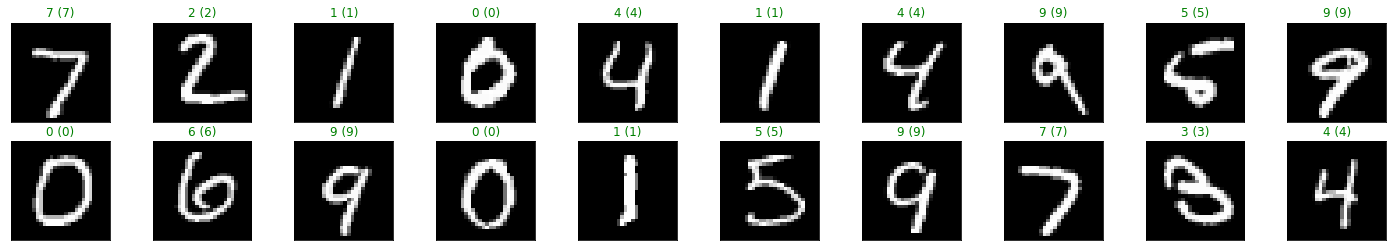

In [13]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()# get sample outputs
if cuda:
    model.to(device)
    images, labels = images.to(device), labels.to(device)
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.cpu().numpy()# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))